3NID_L 3NID_H
5BV7_L 5BV7_H
5BV7_B 5BV7_C
7RAH_A 7RAH_B
7RAH_C 7RAH_D
3NIG_L 3NIG_H
5DHV_B 5DHV_A
5DHV_L 5DHV_H
6M3B_D 6M3B_A
6M3B_B 6M3B_C
6MTJ_E 6MTJ_D
6MTJ_L 6MTJ_H
6CW2_B 6CW2_A
1EZV_Y 1EZV_X
6VEP_D 6VEP_C
5LSP_L 5LSP_H
4K3J_L 4K3J_H
6FGB_L 6FGB_H
7JOO_L 7JOO_H
6O1F_L 6O1F_H
5K59_L 5K59_H
5E8E_A 5E8E_B
5E8E_L 5E8E_H
5HBT_C 5HBT_D
6WZK_B 6WZK_A
6WZK_D 6WZK_C
6CW3_B 6CW3_A
6MU6_L 6MU6_H
6MU6_E 6MU6_D
6XP6_G 6XP6_H
3GBN_L 3GBN_H
6TYB_L 6TYB_H
3O0R_L 3O0R_H
3HMX_L 3HMX_H
4LVN_B 4LVN_C
4R8W_L 4R8W_H
7AHU_L 7AHU_H
6U2F_L 6U2F_H
1RJL_A 1RJL_B
6IAP_D 6IAP_E
6IAP_L 6IAP_H
5TQ0_L 5TQ0_H
6OGX_D 6OGX_C
6OGX_L 6OGX_H
7KYO_L 7KYO_H
1XIW_C 1XIW_D
3VI3_E 3VI3_F
6UMG_L 6UMG_H
6OOR_L 6OOR_H
1XF5_A 1XF5_B
1W72_L 1W72_H
7L0N_B 7L0N_A
7L0N_L 7L0N_H
5X2N_L 5X2N_H
4XTR_D 4XTR_C
7DFA_L 7DFA_H
3D85_A 3D85_B
3VI4_E 3VI4_F
6UJ9_L 6UJ9_H
6WMW_L 6WMW_H
6WMW_N 6WMW_M
6LZ9_L 6LZ9_H
3B9K_C 3B9K_D
6CRK_B 6CRK_H
7JTR_A 7JTR_B
6I07_C 6I07_A
6PCU_G 6PCU_E
6OAN_A 6OAN_B
7K93_B 7K93_G
4NIK_A 4NIK_B
2HMI_C 2HMI_D
1NFD_E

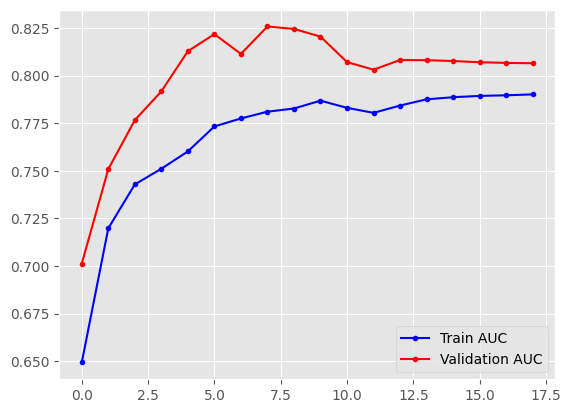

In [7]:
###
# Define a toy model: more complex models in experiments/qm9/models.py
###
import os
import json
import torch
import shutil
import torch.nn as nn
from matplotlib import pyplot as plt
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score
from datetime import time, datetime
from torch.optim.lr_scheduler import StepLR
from torch_geometric.graphgym import optim
from torch_geometric.nn import global_mean_pool
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import metrics
from equivariant_attention.fibers import Fiber
from equivariant_attention.modules import get_basis_and_r, GSE3Res, GNormSE3, GConvSE3, GMaxPooling
from kfold import divide_5fold_bep3
from zy_pytorchtools import EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from Bio.PDB import PDBParser
import numpy as np
from scipy.spatial.distance import cdist

torch.manual_seed(1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# The maximum feature type is harmonic degree 3

num_degrees = 1
num_features = 6  
edge_dim = 12

fiber_in = Fiber(1, num_features)  
fiber_mid = Fiber(num_degrees, 32)  
fiber_out = Fiber(1, 128)  


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.GSE3Res = GSE3Res(fiber_in, fiber_mid, edge_dim)
        self.GNormSE3 = GNormSE3(fiber_mid)
        self.GConvSE3 = GConvSE3(fiber_mid, fiber_out, edge_dim=edge_dim, self_interaction=True)

    def build_se3(self):
        se3 = nn.ModuleList([self.GSE3Res,
                             self.GNormSE3,
                             self.GConvSE3
                             ])
        return se3

    def forward(self, data):
        # 假设data包含了图G和坐标pos
        G1 = data.G[0]
        basis, r = get_basis_and_r(G1, num_degrees - 1)
        Se3Transformer = self.build_se3()
        features = {'0': G1.ndata['f']}
        for layer in Se3Transformer:
            features = layer(features, G=G1, r=r, basis=basis)
        out = features['0'][..., -1].unsqueeze(0)
        
        # 获取点的坐标
        pos = G1.ndata['pos']
        
        return out, pos  # 返回特征和对应点的坐标


def read_pairs(filename):
    pairs = []
    with open(filename, 'r') as file:
        for line in file:
            pairs.append(line.strip().split(','))
    return pairs

def load_data_and_create_loaders(data_folder, pairs_filename, device):
    antigen_loaders = []
    antibody_loaders = []
    
    # 读取抗原和抗体对
    pairs = read_pairs(pairs_filename)
    
    # 对于每对抗原和抗体，加载数据并创建DataLoader
    for pair in pairs:
        antigen_name, antibody_name = pair
        print(antigen_name, antibody_name)
        # 构建文件路径
        antigen_path = os.path.join(data_folder, antigen_name + '.pt')
        antibody_path = os.path.join(data_folder, antibody_name + '.pt')
        
        # 加载数据
        antigen_data = torch.load(antigen_path, map_location=device)
        antibody_data = torch.load(antibody_path, map_location=device)
        
        # 创建DataLoaders
        antigen_loader = DataLoader([antigen_data], batch_size=1, shuffle=True, drop_last=True)
        antibody_loader = DataLoader([antibody_data], batch_size=1, shuffle=True, drop_last=True)
        
        # 添加到列表
        antigen_loaders.append(antigen_loader)
        antibody_loaders.append(antibody_loader)
    
    return antigen_loaders, antibody_loaders
def get_date():
    return datetime.now().strftime("%d/%m/%Y %H:%M:%S")
def calculate_distances_matrix(antibody_pos, antigen_pos):
    # 使用torch.cdist计算两组点之间的欧几里得距离
    distances = torch.cdist(antibody_pos, antigen_pos)

    # 将距离大于4.5的设置为0，否则设置为1
    distances_matrix = torch.where(distances > 4.5, torch.zeros_like(distances), torch.ones_like(distances))

    return distances_matrix

def clear_folder(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # 删除文件或链接
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # 删除文件夹
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')

def plot_metrics(history, saved_model_dir, model_name="training_plot"):
    plt.style.use('ggplot')

    figures_dir = saved_model_dir + '/' + model_name +'_figs/'
    if not os.path.exists(figures_dir):
        os.mkdir(figures_dir)
    # plot losses:
    plt.plot(history['train_loss'], marker='.', color='b', label='Train loss')
    plt.plot(history['val_loss'], marker='.', color='r', label='Validation loss')
    plt.legend(loc="upper right")
    plt.savefig(figures_dir+'/loss_{}.png'.format(model_name))
    plt.clf()
    plt.plot(history['train_auc'], marker='.', color='b', label='Train AUC')
    plt.plot(history['val_auc'], marker='.', color='r', label='Validation AUC')
    plt.legend(loc="lower right")
    plt.savefig(figures_dir+'/auc_{}.png'.format(model_name))
    
def add_to_history(history, train_loss, val_loss,train_auc, val_auc):
    history['train_loss'].append(float(train_loss))
    history['val_loss'].append(float(val_loss))
    history['train_auc'].append(float(train_auc))
    history['val_auc'].append(float(val_auc))

    return history
def compute_performance(output, label):
    pred_probabilities = output.cpu().detach().numpy()
    label = label.cpu().detach().numpy()
    flat_true_labels = label.flatten()
    flat_pred_probabilities = pred_probabilities.flatten()
    auc = metrics.roc_auc_score(flat_true_labels, flat_pred_probabilities)
    return auc
def train_one_epoch(antigen_model, antibody_model, antigen_loaders, antibody_loaders, optimizer, criterion, device):
    print("train",device)
    antigen_model.train()
    antibody_model.train()
    running_loss = []
    running_auc = []
    optimizer.zero_grad()
    for i, (antigen_loader, antibody_loader) in enumerate(zip(antigen_loaders, antibody_loaders)):
        for antigen_data, antibody_data in zip(antigen_loader, antibody_loader):
            antigen_data = antigen_data.to(device)
            antibody_data = antibody_data.to(device)
            antigen_features,antigen_pos=antigen_model(antigen_data)
            antibody_features,antibody_pos=antigen_model(antibody_data)
            save_path = os.path.join(r"./label", f"train_distances_matrix_{i}.pt")
            
            # 检查是否已经计算并保存了距离矩阵
            if os.path.exists(save_path):
                label = torch.load(save_path)
            else:
                # 计算距离矩阵并保存
                label = calculate_distances_matrix(antigen_pos, antibody_pos)
                torch.save(label, save_path)
            
            # 将label转回设备
            label = label.to(device)
            if torch.all(label == 0):
                continue  # 如果label全为0，则跳过
            print(label.shape)
            antigen_vector_normalized = F.normalize(antigen_features, p=2, dim=2)
            antibody_vector_normalized = F.normalize(antibody_features, p=2, dim=2)
            #  转置 antibody_vector 以匹配矩阵乘法的要求
            antibody_vector_normalized = antibody_vector_normalized.transpose(1, 2)
            print(antigen_vector_normalized.shape)
            print(antibody_vector_normalized.shape)
            predict = torch.bmm(antigen_vector_normalized, antibody_vector_normalized)
            predict = predict[0]
            print("predict",predict.size())
            loss = criterion(predict,label)
            auc = compute_performance(predict, label)
            optimizer.zero_grad()  # 清除旧梯度
            loss.backward()        # 计算新梯度
            optimizer.step()       # 更新参数
            running_loss.append(loss.item())
            running_auc.append(auc)
            print("over",i)
    antigen_model.eval()
    antibody_model.eval()
    train_loss = np.average(running_loss)    
    train_auc = np.average(running_auc) 
    print("Average training loss: {}; train AUC: {};".format(train_loss, train_auc))
    return antigen_model,antibody_model, train_loss, train_auc
def evaluate_val(antigen_loaders, antibody_loaders,antigen_model, antibody_model,device, criterion=None):
     running_loss =  [] 
     running_auc = []
     antigen_model.eval()
     antibody_model.eval()
     with torch.no_grad():
        for i, (antigen_loader, antibody_loader) in enumerate(zip(antigen_loaders, antibody_loaders)):
            for antigen_data, antibody_data in zip(antigen_loader, antibody_loader):
                antigen_data = antigen_data.to(device)
                antibody_data = antibody_data.to(device)
                antigen_features,antigen_pos=antigen_model(antigen_data)
                antibody_features,antibody_pos=antigen_model(antibody_data)
                save_path = os.path.join(r"./label", f"val_distances_matrix_{i}.pt")
                # 检查是否已经计算并保存了距离矩阵
                if os.path.exists(save_path):
                    label = torch.load(save_path)
                else:
                    # 计算距离矩阵并保存
                    label = calculate_distances_matrix(antigen_pos, antibody_pos)
                    torch.save(label, save_path)
                            # 将label转回设备
                label = label.to(device)
                if torch.all(label == 0):
                    continue  # 如果label全为0，则跳过
                print(label.shape)
                antigen_vector_normalized = F.normalize(antigen_features, p=2, dim=2)
                antibody_vector_normalized = F.normalize(antibody_features, p=2, dim=2)
                #  转置 antibody_vector 以匹配矩阵乘法的要求
                antibody_vector_normalized = antibody_vector_normalized.transpose(1, 2)
                print(antigen_vector_normalized.shape)
                print(antibody_vector_normalized.shape)
                predict = torch.bmm(antigen_vector_normalized, antibody_vector_normalized)
                predict = predict[0]
                loss = criterion(predict,label)
                auc = compute_performance(predict, label)
                running_loss.append(loss.item())
                running_auc.append(auc)
     val_loss = np.average(running_loss)

     val_auc =  np.average(running_auc) 
     return val_loss,val_auc
def save_model(model, save_path, filename):
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    torch.save(model.state_dict(), os.path.join(save_path, filename))
    print(f"Model saved to {os.path.join(save_path, filename)}")
def fit_training(epochs,antigen_model,antibody_model,train_antigen_loaders,train_antibody_loaders,val_antigen_loaders,val_antibody_loaders,optimizer,device,criterion = None,saved_model_dir = './model_saves',patience = 20): 
    print("fit",device)
    history = {'train_loss': [], 'val_loss': [],
               'train_auc':[], 'val_auc':[]
               }

    print("Start training our own model")
    # 初始化 StepLR 调度器
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)    
    max_auc = 0
    decrease = 0
    not_improved = 0
    saved_index = 0
    for e in range(epochs):
        print("[{}] Starting training for epoch {}...".format(get_date(), e))
        antigen_model, antibody_model ,train_loss, train_auc = train_one_epoch(antigen_model,antibody_model,train_antigen_loaders,train_antibody_loaders,optimizer, criterion,device)
        print("Evaluating the model on validation set...".format(e))
        val_loss, val_auc=evaluate_val(val_antigen_loaders, val_antibody_loaders,antigen_model, antibody_model,device, criterion)
        print("Average val loss: {}; val AUC: {};".format(val_loss, val_auc))
        if val_auc>max_auc:
            print('AUC increasing.. {:.4f} >> {:.4f} '.format(max_auc, val_auc))
            max_auc = val_auc
            decrease += 1
            print('saving model on epoch {}...'.format(e))
            save_model(antigen_model, saved_model_dir, 'final_antigen_model.pth')
            save_model(antibody_model, saved_model_dir, 'final_antibody_model.pth')
            saved_index = e
            not_improved=0
        else:
            not_improved +=1
        # 更新学习率
        scheduler.step()
        # 打印当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")
        history = add_to_history(history, train_loss, val_loss, train_auc, val_auc)  
        if not_improved==patience:
            print("Stopping training...")
            break
    antigen_model.load_state_dict(torch.load(saved_model_dir + '/{}.pth'.format("final_antigen_model")))
    antibody_model.load_state_dict(torch.load(saved_model_dir + '/{}.pth'.format("final_antibody_model")))
    print("[{}] Done with training.".format(get_date()))
    plot_metrics(history, saved_model_dir)
    with open(saved_model_dir+'/history.json', 'w') as outfile:
        json.dump(history, outfile)
    
    return antigen_model,antibody_model, history, saved_index

def train(data_folder,train_filename,val_filename,epochs=50):
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     antigen_model = Net().to(device)
     antibody_model = Net().to(device)
     train_antigen_loaders, train_antibody_loaders = load_data_and_create_loaders(data_folder, train_filename, device)
     val_antigen_loaders, val_antibody_loaders = load_data_and_create_loaders(data_folder, val_filename, device)
     optimizer = torch.optim.Adam([
        {'params': antigen_model.parameters(), 'lr': 0.001,'weight_decay':0.0001}, 
        {'params': antibody_model.parameters(), 'lr': 0.001,'weight_decay':0.0001}
        ])
     critertion = nn.CrossEntropyLoss()
     antigen_model, antibody_model, history, saved_index =fit_training(epochs,antigen_model,antibody_model,train_antigen_loaders,train_antibody_loaders,val_antigen_loaders,val_antibody_loaders,optimizer,device,criterion = critertion,saved_model_dir = './model_saves',patience = 10) 
     clear_folder(r"./label")
     return antigen_model,antibody_model, history, saved_index

data_folder = './data'  # 数据所在文件夹
train_filename = r'train.txt' 
val_filename = r'val.txt' 
antigen_model,antibody_model, history, saved_index=train(data_folder,train_filename,val_filename,epochs=20)